# 问题描述

分别在 `digits` 和 `20newsgroups` 两个数据集上做以下聚类算法：

* K-Means
* Affinity propagation
* Mean-shift
* Spectral clustering
* Agglomerative clustering
* DBSCAN
* Gaussian mixtures

并按照以下评估标准进行评估：

- **Normalized Mutual Information** (NMI) 归一化互信息
    - `metrics.normalized_mutual_info_score(labels_true, labels_pred)`
- **Homogeneity**: each cluster contains only members of a single class 每个集群只包含一个类的成员
    - `metrics.homogeneity_score(labels_true, labels_pred)`
- **Completeness**: all members of a given class are assigned to the same cluster 给定类的所有成员都被分配到同一个集群
    - `metrics.completeness_score(labels_true, labels_pred)`

In [2]:
from matplotlib import pyplot as plt
from sklearn import cluster
from sklearn import datasets
from sklearn import metrics
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# 数据集
## Digits 数据集

In [3]:
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


target_names: [0 1 2 3 4 5 6 7 8 9]
target: 0
images: [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
data: [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


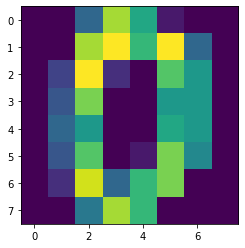

In [4]:
print('target_names:', digits.target_names)
print('target:', digits.target[0])
print('images:', digits.images[0])
print('data:', digits.data[0])
plt.imshow(digits.images[0])

In [5]:
X = scale(digits.data)

## 20newsgroups 数据集

In [6]:
news = datasets.fetch_20newsgroups()
print(news.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [7]:
print('target_names:', news.target_names)
print('\ntarget:', news.target[0])
print('\nfilenames:', news.filenames[0])
print('\ndata:', news.data[0])

target_names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

target: 7

filenames: C:\Users\59502\scikit_learn_data\20news_home\20news-bydate-train\rec.autos\102994

data: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If a

# 聚类算法

## 评估对比函数

In [8]:
def evaluate(labels_true, labels_pred, name):
    print('%-20s\t%.3f\t%.3f\t%.3f' % (
          name,
          metrics.v_measure_score(labels_true, labels_pred),
          metrics.homogeneity_score(labels_true, labels_pred),
          metrics.completeness_score(labels_true, labels_pred),
         ))

## 图形化展示函数（abort）

In [16]:
def visualize(x, y_pred):
    x = PCA(n_components=2).fit_transform(x)
    plt.scatter(x[:, 0], x[:, 1], c=y_pred)
    plt.show()

## 聚类

--------------------------------------------------
                    	NMI	Homo	Comp
k-means             	0.690	0.670	0.712
AffinityPropagation 	0.616	0.932	0.460
MeanShift           	0.660	0.833	0.546
SpectralClustering  	0.828	0.805	0.853
AgglomerativeClustering	0.796	0.758	0.836
DBSCAN              	0.621	0.887	0.477
GaussianMixture     	0.679	0.657	0.702
--------------------------------------------------


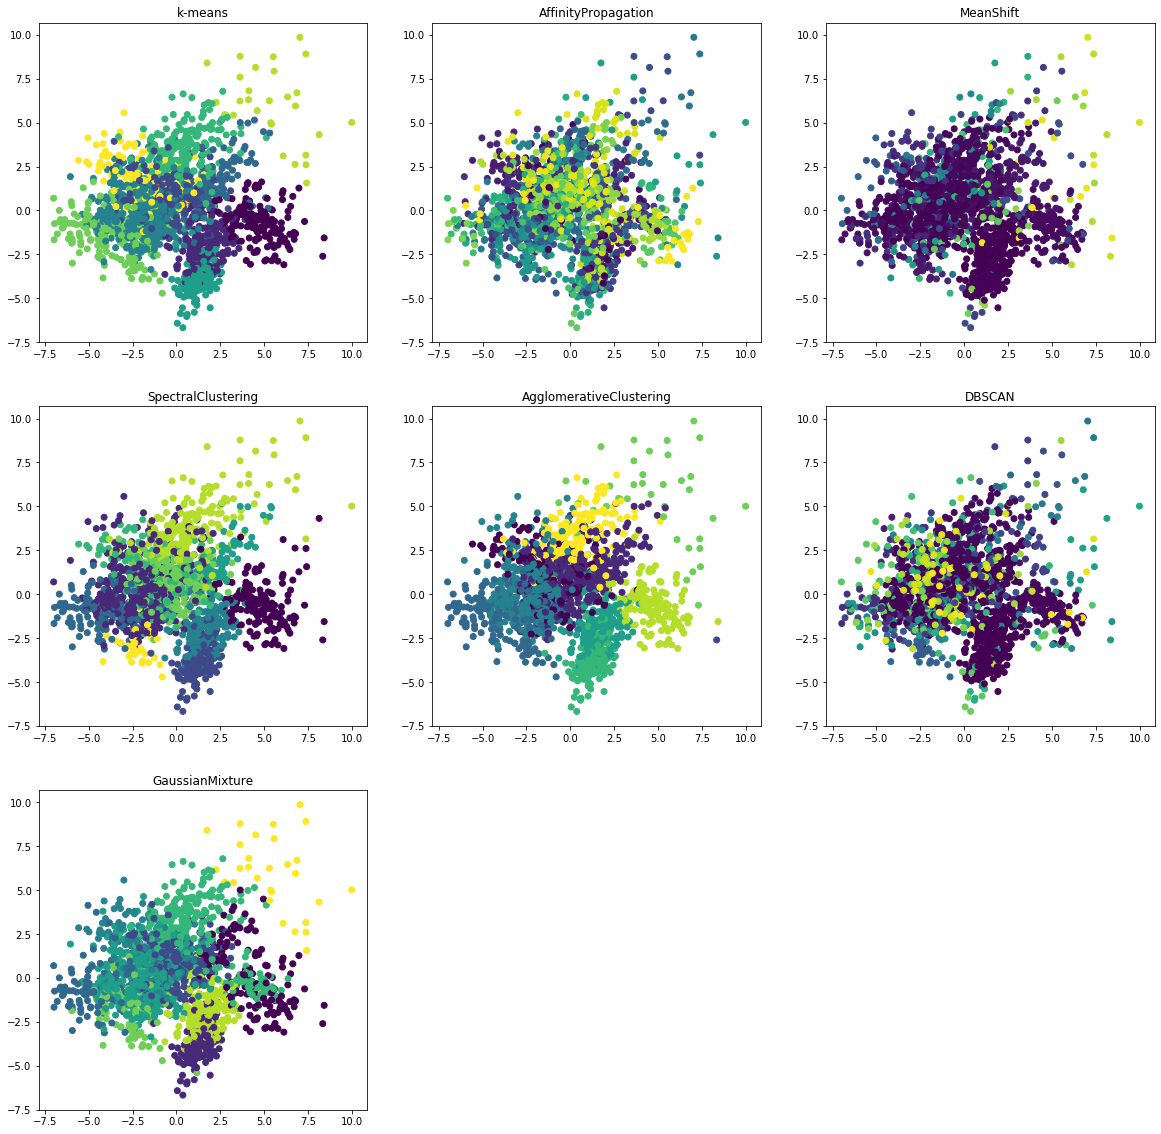

In [18]:
print('-' * 50)
print('%-20s\t%s\t%s\t%s' % ('', 'NMI', 'Homo', 'Comp'))
plt.figure(figsize=(20, 20))
x_compress = PCA(n_components=2).fit_transform(X)

y_pred = cluster.KMeans(n_clusters=10, random_state=9).fit_predict(X)
evaluate(digits.target, y_pred, 'k-means')
plt.subplot(331).set_title('k-means')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AffinityPropagation().fit_predict(X)
evaluate(digits.target, y_pred, 'AffinityPropagation')
plt.subplot(332).set_title('AffinityPropagation')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.MeanShift(bandwidth=5).fit_predict(X)
evaluate(digits.target, y_pred, 'MeanShift')
plt.subplot(333).set_title('MeanShift')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.SpectralClustering(n_clusters=10, affinity='nearest_neighbors').fit_predict(X)
evaluate(digits.target, y_pred, 'SpectralClustering')
plt.subplot(334).set_title('SpectralClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.AgglomerativeClustering(n_clusters=10).fit_predict(X)
evaluate(digits.target, y_pred, 'AgglomerativeClustering')
plt.subplot(335).set_title('AgglomerativeClustering')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = cluster.DBSCAN(eps=4, min_samples=1).fit_predict(X)
evaluate(digits.target, y_pred, 'DBSCAN')
plt.subplot(336).set_title('DBSCAN')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

y_pred = mixture.GaussianMixture(n_components=10).fit_predict(X)
evaluate(digits.target, y_pred, 'GaussianMixture')
plt.subplot(337).set_title('GaussianMixture')
plt.scatter(x_compress[:, 0], x_compress[:, 1], c=y_pred)

print('-' * 50)
plt.show()

# 附

## 各聚类算法效果转载

![](http://img.qingtingip.com/crawler/article/2019514/e7232fd2c86616b9a41c73c19ff97326)